In [2]:
from google.colab import drive
# from google.colab import files
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_score, recall_score, f1_score

In [4]:
# Force TensorFlow to use the CPU
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Load your dataset
data = pd.read_csv('/content/drive/MyDrive/skin_lesion/undersampled_balanced_ham10000.csv')

# Assuming the last column is the label for binary classification
X = data.iloc[:, :-1].values  # Features
y = data.iloc[:, -1].values   # Labels

In [5]:
# Rescale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape the data for CNN input without altering the shape
X_scaled = X_scaled.reshape(X.shape[0], 64, 64, 3)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2

# Build a CNN model with L2 regularization and dropout
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=(64, 64, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),  # L2 regularization added
    Dropout(0.5),  # Dropout to prevent overfitting
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001))  # L2 regularization on output
])



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
# Define Data Generator for Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Fit the data generator to the training data
datagen.fit(X_train)


In [13]:

# Define Learning Rate Reduction and Early Stopping
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=0.00001, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Custom callback to print precision, recall, and F1 score after each epoch
class MetricsCallback(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        X_val, y_val = self.validation_data
        y_pred = (self.model.predict(X_val) > 0.5).astype(int)
        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)

        print(f"Epoch {epoch + 1} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")


In [14]:
# Train the model with the custom callback
batch_size = 32
epochs =30
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    epochs=epochs,
    callbacks=[lr_reduction, early_stopping, MetricsCallback(validation_data=(X_test, y_test))]
)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step
Epoch 1 - Precision: 0.7590, Recall: 0.8298, F1-Score: 0.7928
251/251 ━━━━━━━━━━━━━━━━━━━━ 86s 341ms/step - accuracy: 0.8092 - loss: 0.4469 - val_accuracy: 0.7863 - val_loss: 0.4579 - learning_rate: 5.0000e-04
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step
Epoch 2 - Precision: 0.7506, Recall: 0.8784, F1-Score: 0.8095
251/251 ━━━━━━━━━━━━━━━━━━━━ 70s 276ms/step - accuracy: 0.8046 - loss: 0.4495 - val_accuracy: 0.7963 - val_loss: 0.4635 - learning_rate: 5.0000e-04
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step
Epoch 3 - Precision: 0.7285, Recall: 0.9108, F1-Score: 0.8095
251/251 ━━━━━━━━━━━━━━━━━━━━ 71s 282ms/step - accuracy: 0.8031 - loss: 0.4494 - val_accuracy: 0.7888 - val_loss: 0.4607 - learning_rate: 5.0000e-04
Epoch 4/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.7974 - loss: 0.4562
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step
Epoch 4 - Precision: 0.7

In [15]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.8117 - loss: 0.4243
Test Accuracy: 82.08%


In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,875,845 (18.60 MB)

 Trainable params: 1,625,281 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,250,564 (12.40 MB)

In [32]:
model.save("FINAL_CNN_model.h5")
model.save('FINAL_CNN_model.keras')

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

# Predictions
# y_train_pred = model.predict(X_train)
# y_train_pred_classes = np.argmax(y_train_pred, axis=1)
# y_train_true_classes = np.argmax(y_train, axis=1)

# y_test_pred = model.predict(X_test)
# y_test_pred_classes = np.argmax(y_test_pred, axis=1)
# y_test_true_classes = np.argmax(y_test, axis=1)

y_train_pred = model.predict(X_train)
y_train_pred_classes = (y_train_pred > 0.5).astype(int) # Convert probabilities to class labels (0 or 1)
#y_train_true_classes = np.argmax(y_train, axis=1) # This line is removed
y_train_true_classes = y_train # y_train already contains the true class labels

y_test_pred = model.predict(X_test)
y_test_pred_classes = (y_test_pred > 0.5).astype(int) # Convert probabilities to class labels (0 or 1)
#y_test_true_classes = np.argmax(y_test, axis=1) # This line is removed
y_test_true_classes = y_test # y_test already contains the true class labels

# Metrics
train_precision = precision_score(y_train_true_classes, y_train_pred_classes, average='weighted', zero_division=0)
train_recall = recall_score(y_train_true_classes, y_train_pred_classes, average='weighted', zero_division=0)
train_f1 = f1_score(y_train_true_classes, y_train_pred_classes, average='weighted')
train_accuracy = accuracy_score(y_train_true_classes, y_train_pred_classes)

test_precision = precision_score(y_test_true_classes, y_test_pred_classes, average='weighted', zero_division=0)
test_recall = recall_score(y_test_true_classes, y_test_pred_classes, average='weighted', zero_division=0)
test_f1 = f1_score(y_test_true_classes, y_test_pred_classes, average='weighted')
test_accuracy = accuracy_score(y_test_true_classes, y_test_pred_classes)

# Print Metrics
print("Training Metrics:")
print(f"Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1-Score: {train_f1:.4f}")

print("\nTesting Metrics:")
print(f"Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1-Score: {test_f1:.4f}")

251/251 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step
Training Metrics:
Accuracy: 0.8459, Precision: 0.8513, Recall: 0.8459, F1-Score: 0.8454

Testing Metrics:
Accuracy: 0.8208, Precision: 0.8263, Recall: 0.8208, F1-Score: 0.8202


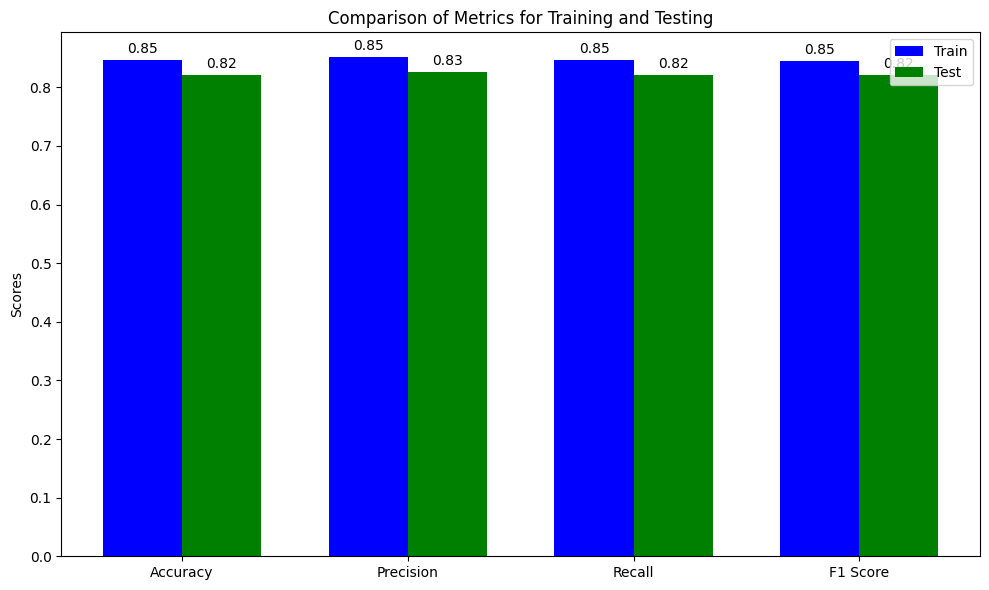

In [19]:
# Prepare data for plotting
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
train_values = [train_accuracy, train_precision, train_recall, train_f1]
test_values = [test_accuracy, test_precision, test_recall, test_f1]

# Set up the bar plot
width = 0.35  # Width of the bars
x = np.arange(len(metrics))  # The label locations

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the bars for training and testing metrics
rects1 = ax.bar(x - width/2, train_values, width, label='Train', color='blue')
rects2 = ax.bar(x + width/2, test_values, width, label='Test', color='green')

# Add some text for labels, title and custom x-axis tick labels
ax.set_ylabel('Scores')
ax.set_title('Comparison of Metrics for Training and Testing')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Function to add the labels on top of the bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Add labels for each bar
add_labels(rects1)
add_labels(rects2)

# Show the plot
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


251/251 ━━━━━━━━━━━━━━━━━━━━ 18s 72ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.75      0.79      1016
           1       0.76      0.84      0.80       987

    accuracy                           0.80      2003
   macro avg       0.80      0.80      0.80      2003
weighted avg       0.80      0.80      0.79      2003


Metrics:
Precision: 0.7649
Recall: 0.8440
F1-Score: 0.8025
AUC-ROC: 0.8869
Accuracy: 0.7953


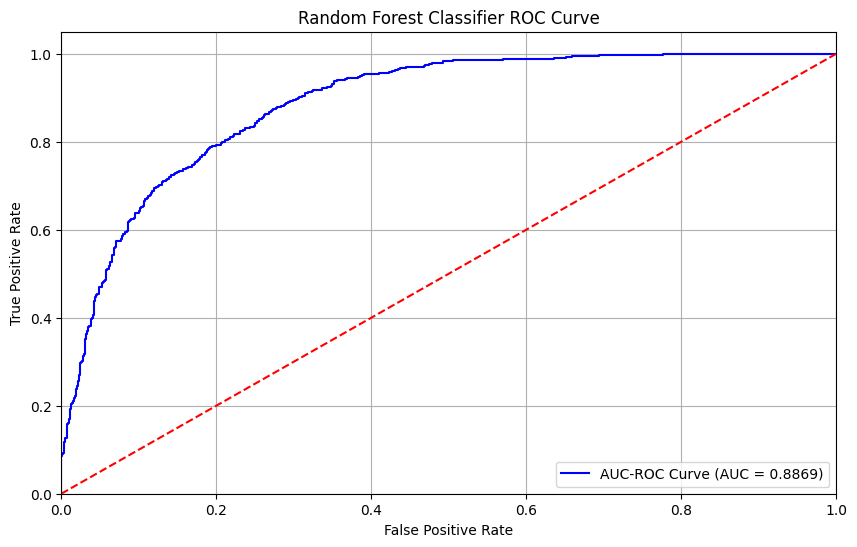

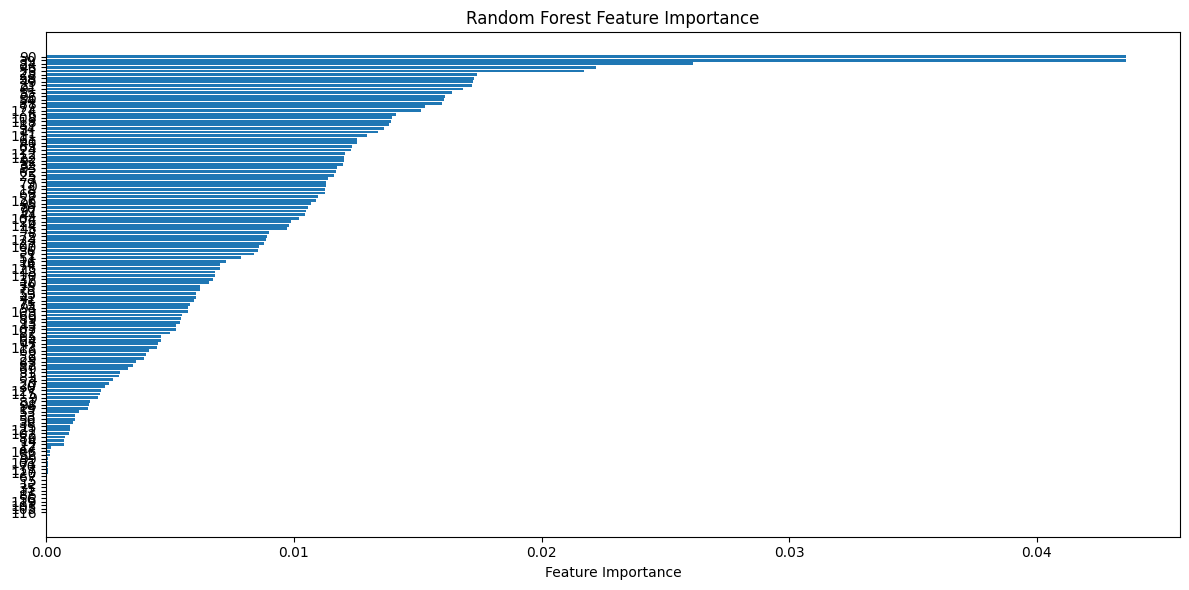

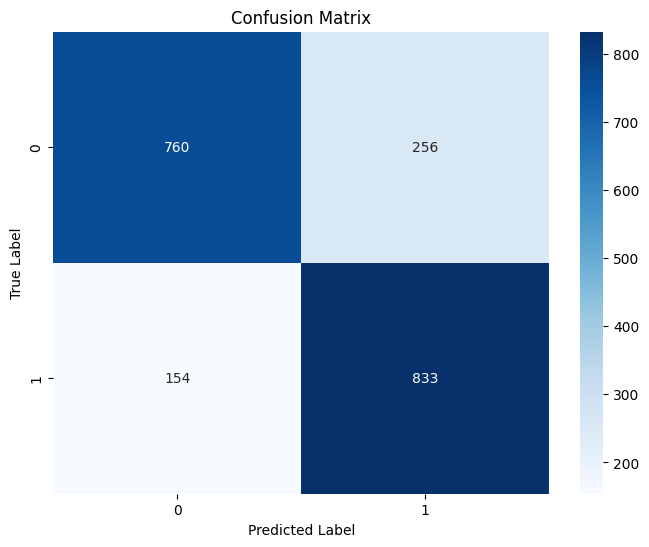

In [20]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    classification_report,
    confusion_matrix,
    accuracy_score  # Import accuracy_score
)
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Force TensorFlow to use CPU
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Load Dataset
data = pd.read_csv('/content/drive/MyDrive/skin_lesion/undersampled_balanced_ham10000.csv')

# Prepare Features and Labels
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = X_scaled.reshape(X.shape[0], 64, 64, 3)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# CNN Feature Extraction Model
def create_feature_extractor():
    base_model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu')
    ])
    base_model.compile(optimizer=Adam(learning_rate=0.001),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])
    return base_model

# Create Feature Extractor
feature_extractor = create_feature_extractor()

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=False
)
datagen.fit(X_train)

# Extract Features
features_train = feature_extractor.predict(X_train)
features_test = feature_extractor.predict(X_test)

# Random Forest Classifier with Advanced Configuration
rf_classifier = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=True,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

# Train Random Forest Classifier
rf_classifier.fit(features_train, y_train)

# Predictions
y_pred = rf_classifier.predict(features_test)
y_pred_proba = rf_classifier.predict_proba(features_test)[:, 1]

# Performance Metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy

# Print Detailed Classification Report and Accuracy
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"\nMetrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")  # Print accuracy

# AUC-ROC Curve Plotting
plt.figure(figsize=(10, 6))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.plot(fpr, tpr, color='blue',
         label=f'AUC-ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest Classifier ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Feature Importance Visualization
plt.figure(figsize=(12, 6))
feature_importance = rf_classifier.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, sorted_idx)
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


251/251 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.67      0.75      1016
           1       0.72      0.87      0.79       987

    accuracy                           0.77      2003
   macro avg       0.78      0.77      0.77      2003
weighted avg       0.78      0.77      0.77      2003


Metrics:
Precision: 0.7193
Recall: 0.8673
F1-Score: 0.7864
AUC-ROC: 0.8320
Accuracy: 0.7678


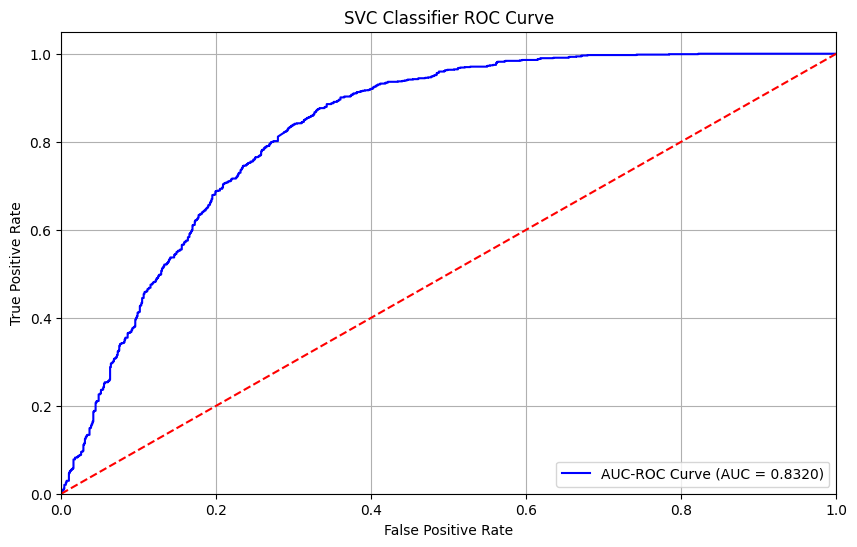

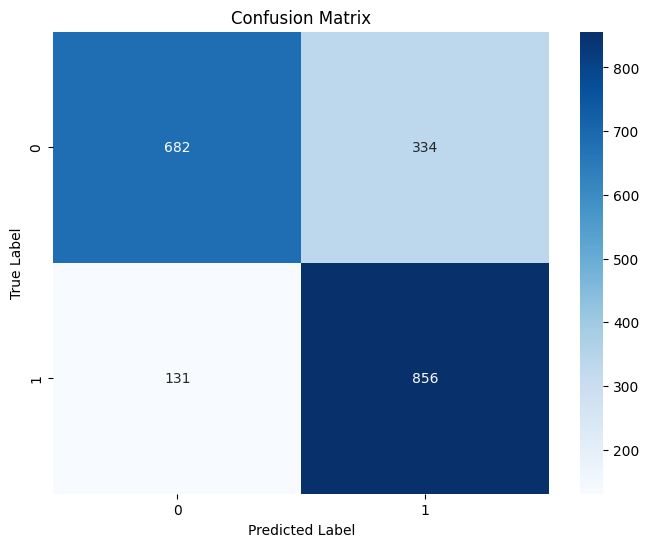

In [21]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    classification_report,
    confusion_matrix,
    accuracy_score
)
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Force TensorFlow to use CPU
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Load Dataset
data = pd.read_csv('/content/drive/MyDrive/skin_lesion/undersampled_balanced_ham10000.csv')

# Prepare Features and Labels
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = X_scaled.reshape(X.shape[0], 64, 64, 3)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# CNN Feature Extraction Model
def create_feature_extractor():
    base_model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu')
    ])
    base_model.compile(optimizer=Adam(learning_rate=0.001),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])
    return base_model

# Create Feature Extractor
feature_extractor = create_feature_extractor()

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=False
)
datagen.fit(X_train)

# Extract Features
features_train = feature_extractor.predict(X_train)
features_test = feature_extractor.predict(X_test)

# SVC Classifier with Advanced Configuration
svc_classifier = SVC(
    kernel='rbf',
    C=1.0,
    probability=True,
    random_state=42
)

# Train SVC Classifier
svc_classifier.fit(features_train, y_train)

# Predictions
y_pred = svc_classifier.predict(features_test)
y_pred_proba = svc_classifier.predict_proba(features_test)[:, 1]

# Performance Metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
accuracy = accuracy_score(y_test, y_pred)

# Print Detailed Classification Report and Accuracy
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"\nMetrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# AUC-ROC Curve Plotting
plt.figure(figsize=(10, 6))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.plot(fpr, tpr, color='blue',
         label=f'AUC-ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVC Classifier ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [25]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier  # Import XGBoost classifier
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    classification_report,
    confusion_matrix,
    accuracy_score
)
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Force TensorFlow to use CPU
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Load Dataset
data = pd.read_csv('/content/drive/MyDrive/skin_lesion/undersampled_balanced_ham10000.csv')

# Prepare Features and Labels
X = data.iloc[:, :-1].values  # Features
y = data.iloc[:, -1].values   # Labels

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = X_scaled.reshape(X.shape[0], 64, 64, 3)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# CNN Feature Extraction Model
def create_feature_extractor():
    base_model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu')
    ])
    base_model.compile(optimizer=Adam(learning_rate=0.001),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])
    return base_model

# Create Feature Extractor
feature_extractor = create_feature_extractor()

# Data Augmentation (not used for feature extraction here)
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)

# Fit the data generator to the training data (not necessary for feature extraction)
datagen.fit(X_train)

# Extract Features from the CNN Model (without training)
features_train = feature_extractor.predict(X_train)
features_test = feature_extractor.predict(X_test)

# XGBoost Classifier with Advanced Configuration
xgb_classifier = XGBClassifier(
    n_estimators=200,
    max_depth=15,
    learning_rate=0.1,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)

# Train XGBoost Classifier on extracted features
xgb_classifier.fit(features_train.reshape(features_train.shape[0], -1), y_train)

# Predictions on test set
y_pred = xgb_classifier.predict(features_test.reshape(features_test.shape[0], -1))
y_pred_proba = xgb_classifier.predict_proba(features_test.reshape(features_test.shape[0], -1))[:, 1]  # Get probabilities for positive class

# Calculate performance metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy

# Print Detailed Classification Report and Accuracy
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"\nMetrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")  # Print accuracy

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


251/251 ━━━━━━━━━━━━━━━━━━━━ 19s 74ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.79      0.82      1016
           1       0.80      0.87      0.83       987

    accuracy                           0.83      2003
   macro avg       0.83      0.83      0.83      2003
weighted avg       0.83      0.83      0.83      2003


Metrics:
Precision: 0.7987
Recall: 0.8683
F1-Score: 0.8320
AUC-ROC: 0.9138
Accuracy: 0.8273


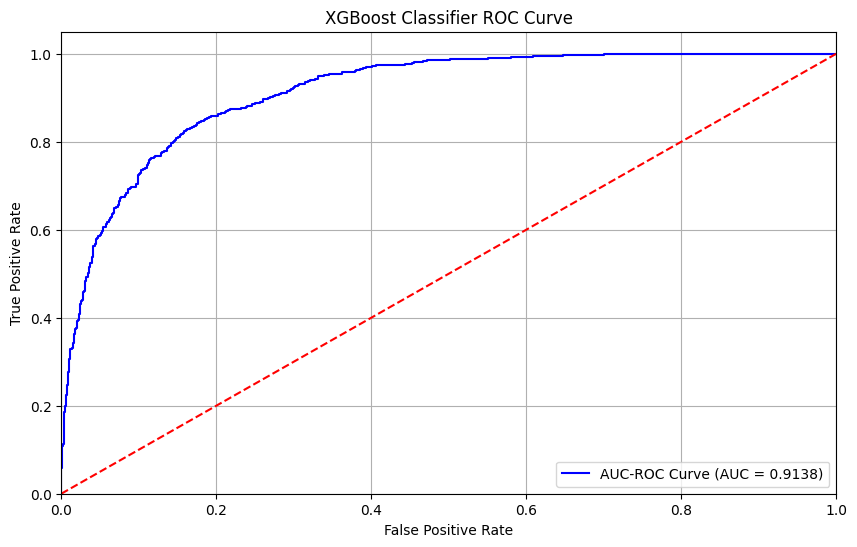

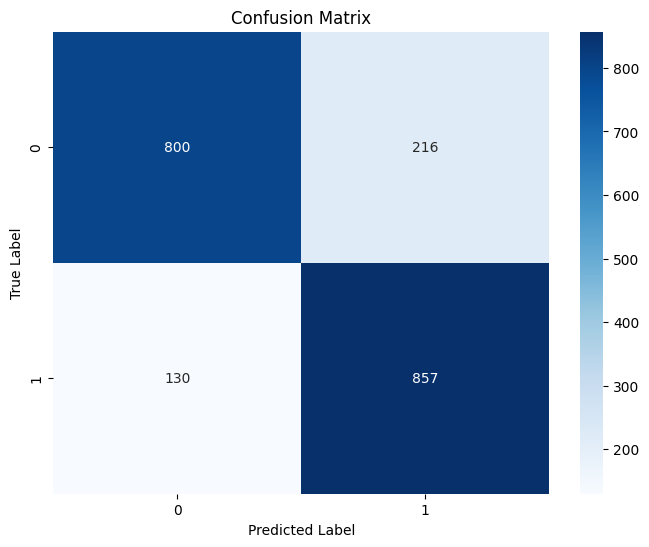

In [26]:
# AUC-ROC Curve Plotting
plt.figure(figsize=(10, 6))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.plot(fpr, tpr, color='blue',
         label=f'AUC-ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost Classifier ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()




<Figure size 1200x600 with 0 Axes>

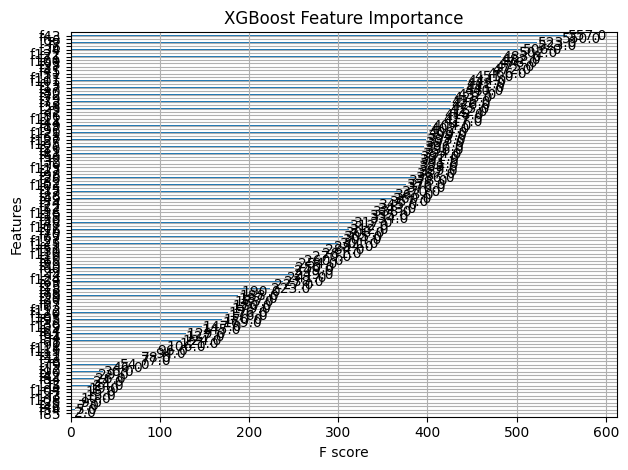

In [27]:
!pip install xgboost
#Import the xgboost library and rename it as xgb
import xgboost as xgb

#Feature Importance Visualization using XGBoost's built-in method


plt.figure(figsize=(12, 6))

xgb.plot_importance(xgb_classifier)
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


251/251 ━━━━━━━━━━━━━━━━━━━━ 19s 74ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.77      0.70      1016
           1       0.70      0.55      0.61       987

    accuracy                           0.66      2003
   macro avg       0.67      0.66      0.65      2003
weighted avg       0.67      0.66      0.66      2003


Metrics:
Precision: 0.6958
Recall: 0.5491
F1-Score: 0.6138
AUC-ROC: 0.6579
Accuracy: 0.6595


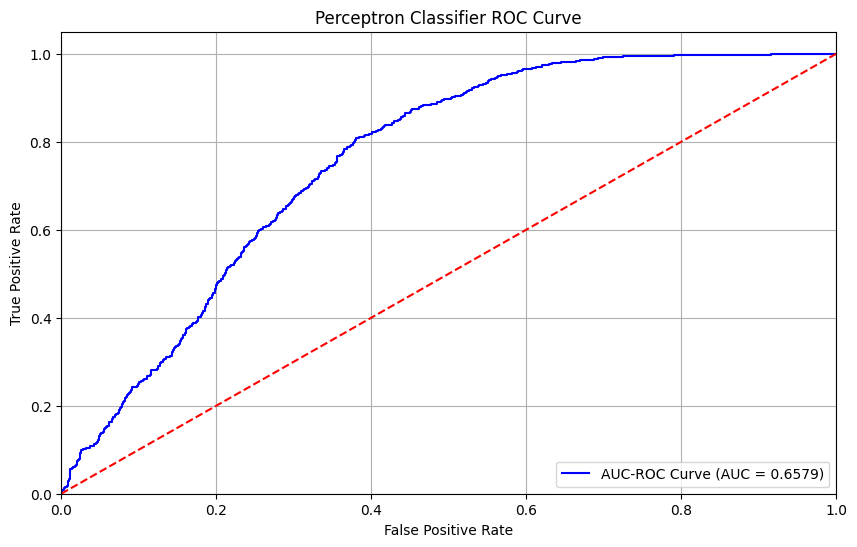

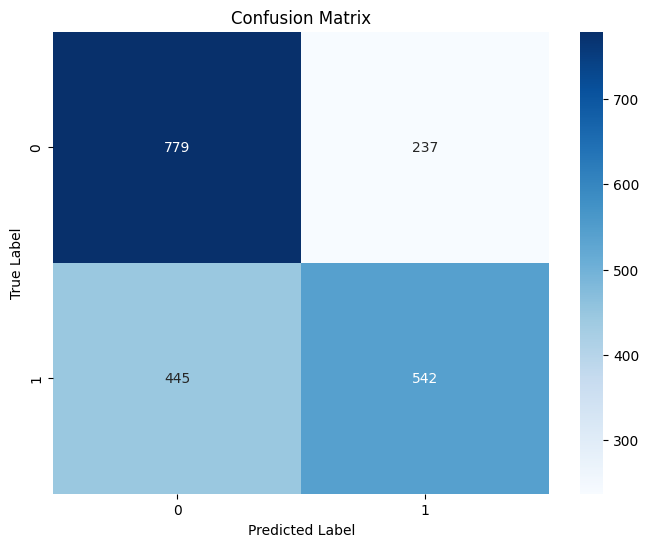

In [28]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron  # Import Perceptron classifier
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    classification_report,
    confusion_matrix,
    accuracy_score
)
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Force TensorFlow to use CPU
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Load Dataset
data = pd.read_csv('/content/drive/MyDrive/skin_lesion/undersampled_balanced_ham10000.csv')

# Prepare Features and Labels
X = data.iloc[:, :-1].values  # Features
y = data.iloc[:, -1].values   # Labels

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = X_scaled.reshape(X.shape[0], 64, 64, 3)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# CNN Feature Extraction Model
def create_feature_extractor():
    base_model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu')
    ])
    base_model.compile(optimizer=Adam(learning_rate=0.001),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])
    return base_model

# Create Feature Extractor
feature_extractor = create_feature_extractor()

# Data Augmentation (not used for feature extraction here)
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)

# Fit the data generator to the training data (not necessary for feature extraction)
datagen.fit(X_train)

# Extract Features from the CNN Model (without training)
features_train = feature_extractor.predict(X_train)
features_test = feature_extractor.predict(X_test)

# Perceptron Classifier
perceptron_classifier = Perceptron(max_iter=1000, tol=1e-3)  # Initialize Perceptron

# Train Perceptron Classifier on extracted features
perceptron_classifier.fit(features_train.reshape(features_train.shape[0], -1), y_train)

# Predictions on test set
y_pred = perceptron_classifier.predict(features_test.reshape(features_test.shape[0], -1))
y_pred_proba = perceptron_classifier.decision_function(features_test.reshape(features_test.shape[0], -1))  # Get decision function values

# Calculate performance metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba > 0)  # Convert decision function to binary predictions for AUC calculation
accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy

# Print Detailed Classification Report and Accuracy
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"\nMetrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")  # Print accuracy

# AUC-ROC Curve Plotting
plt.figure(figsize=(10, 6))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.plot(fpr, tpr, color='blue',
         label=f'AUC-ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Perceptron Classifier ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


251/251 ━━━━━━━━━━━━━━━━━━━━ 20s 77ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.79      0.83      1016
           1       0.80      0.90      0.85       987

    accuracy                           0.84      2003
   macro avg       0.85      0.84      0.84      2003
weighted avg       0.85      0.84      0.84      2003


Metrics:
Precision: 0.8045
Recall: 0.8967
F1-Score: 0.8481
AUC-ROC: 0.9040
Accuracy: 0.8417


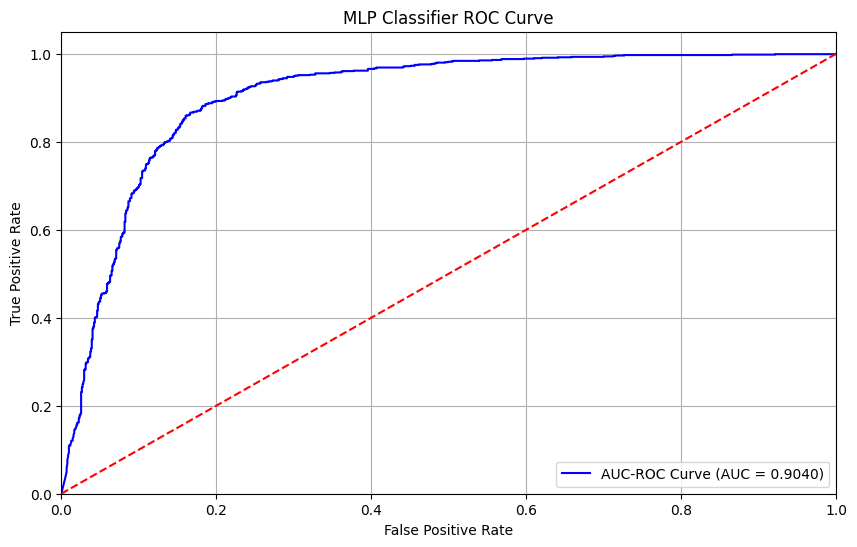

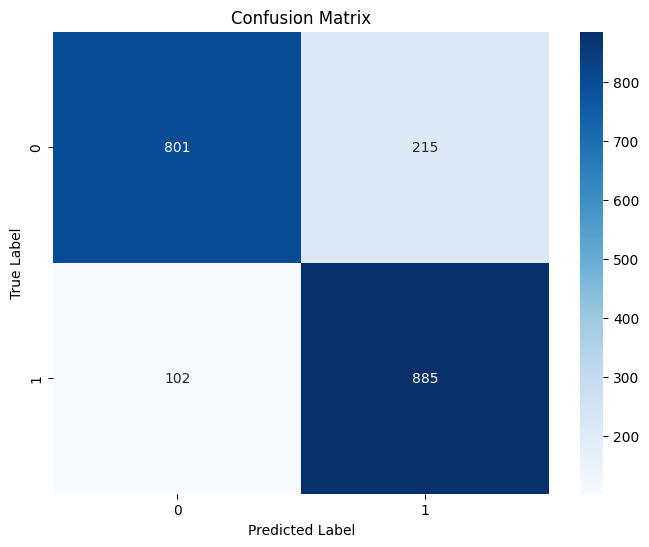

In [29]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier  # Import MLP Classifier
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    classification_report,
    confusion_matrix,
    accuracy_score
)
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Force TensorFlow to use CPU
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Load Dataset
data = pd.read_csv('/content/drive/MyDrive/skin_lesion/undersampled_balanced_ham10000.csv')

# Prepare Features and Labels
X = data.iloc[:, :-1].values  # Features
y = data.iloc[:, -1].values   # Labels

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = X_scaled.reshape(X.shape[0], 64, 64, 3)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# CNN Feature Extraction Model
def create_feature_extractor():
    base_model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu')
    ])
    base_model.compile(optimizer=Adam(learning_rate=0.001),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])
    return base_model

# Create Feature Extractor
feature_extractor = create_feature_extractor()

# Data Augmentation (not used for feature extraction here)
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)

# Fit the data generator to the training data (not necessary for feature extraction)
datagen.fit(X_train)

# Extract Features from the CNN Model (without training)
features_train = feature_extractor.predict(X_train)
features_test = feature_extractor.predict(X_test)

# MLP Classifier with Advanced Configuration
mlp_classifier = MLPClassifier(
    hidden_layer_sizes=(256, 128),  # Two hidden layers with specified sizes
    activation='relu',                # Activation function for hidden layers
    solver='adam',                    # Optimizer
    max_iter=1000,                   # Maximum number of iterations for convergence
    random_state=42,
)

# Train MLP Classifier on extracted features
mlp_classifier.fit(features_train.reshape(features_train.shape[0], -1), y_train)

# Predictions on test set
y_pred = mlp_classifier.predict(features_test.reshape(features_test.shape[0], -1))
y_pred_proba = mlp_classifier.predict_proba(features_test.reshape(features_test.shape[0], -1))[:, 1]  # Get probabilities for positive class

# Calculate performance metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy

# Print Detailed Classification Report and Accuracy
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"\nMetrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")  # Print accuracy

# AUC-ROC Curve Plotting
plt.figure(figsize=(10, 6))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.plot(fpr, tpr, color='blue',
         label=f'AUC-ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MLP Classifier ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


251/251 ━━━━━━━━━━━━━━━━━━━━ 19s 74ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.65      0.74      1016
           1       0.71      0.90      0.80       987

    accuracy                           0.77      2003
   macro avg       0.79      0.77      0.77      2003
weighted avg       0.79      0.77      0.77      2003


Metrics:
Precision: 0.7928
Recall: 0.7723
F1-Score: 0.7689
Accuracy: 0.7723
AUC-ROC: 0.8693


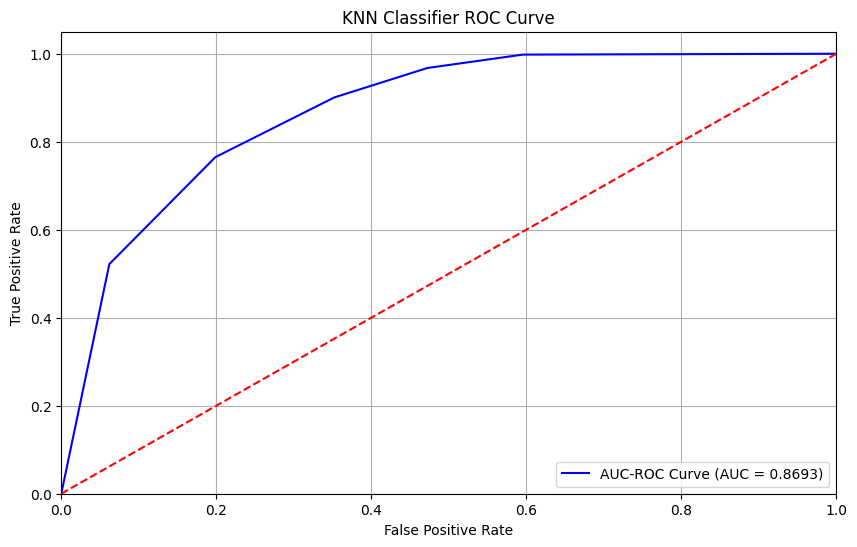

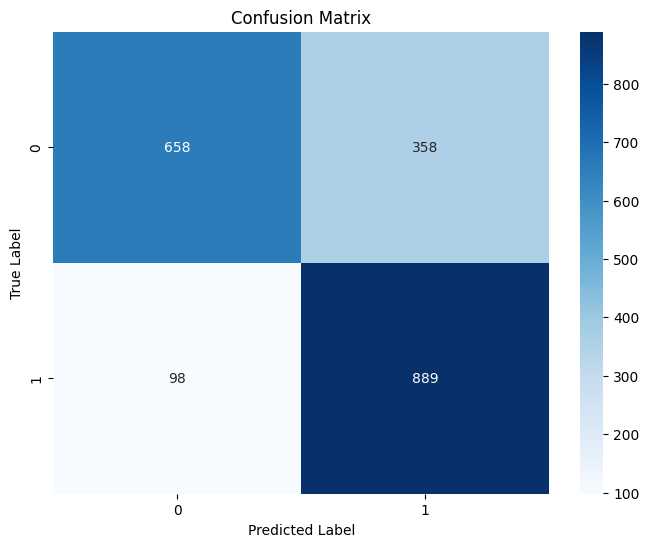

In [30]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier  # Import KNN classifier
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    classification_report,
    confusion_matrix,
    accuracy_score
)
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Force TensorFlow to use CPU
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Load Dataset
data = pd.read_csv('/content/drive/MyDrive/skin_lesion/undersampled_balanced_ham10000.csv')

# Prepare Features and Labels
X = data.iloc[:, :-1].values  # Features
y = data.iloc[:, -1].values   # Labels

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = X_scaled.reshape(X.shape[0], 64, 64, 3)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# CNN Feature Extraction Model
def create_feature_extractor():
    base_model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu')
    ])
    base_model.compile(optimizer=Adam(learning_rate=0.001),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])
    return base_model

# Create Feature Extractor
feature_extractor = create_feature_extractor()

# Data Augmentation (not used for feature extraction here)
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)

# Fit the data generator to the training data (not necessary for feature extraction)
datagen.fit(X_train)

# Extract Features from the CNN Model (without training)
features_train = feature_extractor.predict(X_train)
features_test = feature_extractor.predict(X_test)

# KNN Classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)  # Initialize KNN with 5 neighbors

# Train KNN Classifier on extracted features
knn_classifier.fit(features_train.reshape(features_train.shape[0], -1), y_train)

# Predictions on test set
y_pred = knn_classifier.predict(features_test.reshape(features_test.shape[0], -1))
y_pred_proba = knn_classifier.predict_proba(features_test.reshape(features_test.shape[0], -1))[:, 1] if hasattr(knn_classifier, "predict_proba") else None

# Calculate performance metrics
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else "N/A"

# Print Detailed Classification Report and Accuracy
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"\nMetrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")  # Print accuracy
if y_pred_proba is not None:
    print(f"AUC-ROC: {roc_auc:.4f}")

# AUC-ROC Curve Plotting
if y_pred_proba is not None:
    plt.figure(figsize=(10, 6))
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

    plt.plot(fpr, tpr, color='blue',
             label=f'AUC-ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('KNN Classifier ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
